# Plant Disease Classification

### List of imports

In [1]:
from glob import glob
import pandas.core.common
from torch.utils.data import Dataset
import cv2
import numpy as np
from torchvision.transforms import transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Data preparation
### Creating image path lists
Creating lists of paths where data is saved. Lists are divided - 80% in training set and 20% in test set. Paths are shuffled before assigning.

In [2]:
train_data_path = 'data\\train'

classes, train_image_paths  = [], []

for data_path in glob(train_data_path + '\\*'):
    classes.append(" ".join(" - ".join(data_path.split('\\')[-1].split('___')).split('_')))
    train_image_paths.append(glob(data_path + '\\*'))
    
train_image_paths = list(pandas.core.common.flatten(train_image_paths))

split_index = int(len(train_image_paths) * 0.8)
random.shuffle(train_image_paths)
train_image_paths, test_image_paths = train_image_paths[:split_index], train_image_paths[split_index:]

print('class example: ', classes[0])
print('Path example: ', train_image_paths[0], end='\n\n')

print(f'Classes size: {len(classes)}', end='\n\n')

print(f'Train size: {len(train_image_paths)}')
print(f'Test size: {len(test_image_paths)}')


class example:  Apple - healthy
Path example:  data\train\Blueberry___healthy\49313790-a482-4c62-b8ab-6b5457ec768a___RS_HL 5481.JPG

Classes size: 20

Train size: 22114
Test size: 5529


### Mapping classes with indexes

In [3]:
idx_to_class = {i: j for i, j in enumerate(classes)}
class_to_idx = {value: key for key, value in idx_to_class.items()}

### Creating Datasets
Datasets contain images loaded from provided paths. Each image gets label that inform about type and disease of following plant and is scaled to 256x256 pixels. 

In [4]:
class PlantDataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32)
        image = torch.tensor(image).permute(2, 0, 1)
        
        label = " ".join(" - ".join(image_path.split('\\')[-2].split('___')).split('_'))
        index = class_to_idx[label]
        
        if self.transform:
            image = self.transform(image)
        
        return image, index

transforms = T.Compose([
    T.Resize((256, 256))
])

train_dataset = PlantDataset(train_image_paths, transforms)
test_dataset = PlantDataset(test_image_paths, transforms)

### Data visualization
Visualization of 10 random images from training set.

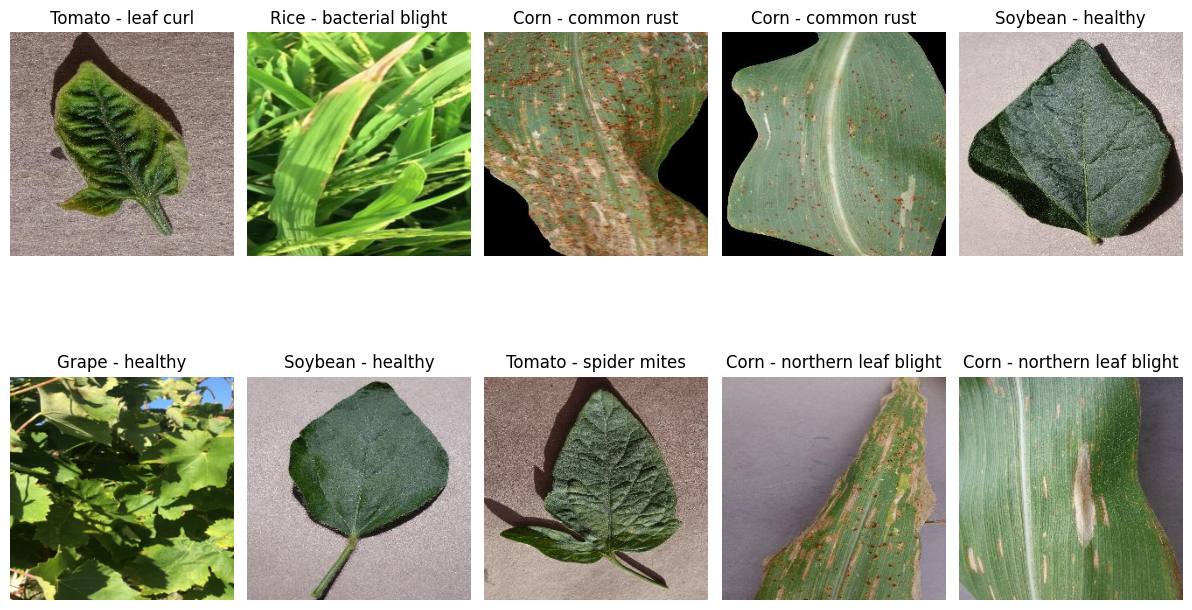

In [5]:
def visualize_augmentations(dataset, samples=10, cols=5):
    rows = samples // cols
    ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))[1]

    for i in range(samples):
        idx = np.random.randint(1,len(train_image_paths))
        image, index = dataset[idx]
        image = image.numpy().astype(np.uint8)
        
        ax.ravel()[i].imshow(np.transpose(image, (1, 2, 0)))
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[index])

    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset)

### Defining dataloaders

In [6]:
train_loader = DataLoader(
    train_dataset, batch_size=32, shuffle=True
)

test_loader = DataLoader(
    test_dataset, batch_size=32, shuffle=False
)

## AI model
### Choosing data processing device.

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

### Defining AI model structure

In [8]:
def convBlock(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
             nn.ReLU(inplace=True)]
    if pool:
        layers.append(nn.MaxPool2d(4))
    return nn.Sequential(*layers)

class NeuralNetwork(nn.Module):
	
    def __init__(self):
        super().__init__()
        
        self.conv1 = convBlock(3, 64)
        self.conv2 = convBlock(64, 128, pool=True) 
        self.res1 = nn.Sequential(convBlock(128, 128), convBlock(128, 128))
        
        self.conv3 = convBlock(128, 256, pool=True)
        self.res2 = nn.Sequential(convBlock(256, 256), convBlock(256, 256))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1),
                                         nn.Flatten(),
                                         nn.Linear(256, len(classes)))
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.conv3(out)
        out = self.res2(out)
        out = F.interpolate(out, scale_factor=2, mode='nearest')
        out = self.classifier(out)
        return out

#### Model creation

In [9]:
net = NeuralNetwork().to(device)
print(net)

NeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res2): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

### Optimizer and criterion creation

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=1e-3)

### Model training and validation

In [ ]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
train_losses, val_losses, train_accs, val_accs = [], [], [], []

start.record()

for epoch in range(10):

    train_loss = 0.0
    train_correct = 0 
    train_total = 0
    net.train()
    for i, train_data in enumerate(train_loader, 0):

        train_inputs, train_labels = train_data
        train_inputs, train_labels = train_inputs.to(device), train_labels.to(device)

        optimizer.zero_grad()
        outputs = net(train_inputs)
        loss = criterion(outputs, train_labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == train_labels).sum().item()
    
    train_loss_avg = train_loss / len(train_loader)
    train_acc = train_correct / len(train_loader.dataset)
    print(f'[Epoch {epoch + 1}] Train loss: {train_loss_avg:.3f}')
    print(f'[Epoch {epoch + 1}] Train acc: {train_acc:.3f}')
    
    valid_loss = 0.0
    valid_correct = 0 
    valid_total = 0
    net.eval()
    with torch.no_grad():
        for i, valid_data in enumerate(test_loader, 0):
            valid_inputs, valid_labels = valid_data
            valid_inputs, valid_labels = valid_inputs.to(device), valid_labels.to(device)
            
            valid_outputs = net(valid_inputs)
            loss = criterion(valid_outputs, valid_labels)
            valid_loss += loss.item()

            _, predicted = torch.max(valid_outputs.data, 1)
            valid_correct += (predicted == valid_labels).sum().item() 

    valid_loss_avg = valid_loss / len(test_loader)
    valid_acc = valid_correct / len(test_loader.dataset)
    print(f'[Epoch {epoch + 1}] Valid loss: {valid_loss_avg:.3f}')
    print(f'[Epoch {epoch + 1}] Valid acc: {valid_acc:.2%}')

    train_losses.append(train_loss_avg) 
    train_accs.append(train_acc)
    val_losses.append(valid_loss_avg)
    val_accs.append(valid_acc)

end.record()
torch.cuda.synchronize()

print('Finished Training')
print(start.elapsed_time(end))

### Save model to file

In [ ]:
torch.save(net.state_dict(), "./models/model8.pth")

### Load model from file

In [11]:
net.load_state_dict(torch.load("./models/model8.pth"))
net.eval()
net.to(device)

NeuralNetwork(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
    )
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (res2): Sequential(
    (0): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

### Drawing loss and accuracy plots

In [12]:
plt.figure(figsize = (10, 5))
plt.plot(train_losses, label = "Train Loss", c = "red")
plt.plot(val_losses, label = "Validation Loss", c = "blue")
plt.xlabel("Epochs")
plt.ylabel("Loss Values")
plt.xticks(ticks = np.arange(len(train_losses)), labels = [i for i in range(1, len(train_losses) + 1)])
plt.legend()
plt.show()

plt.figure(figsize = (10, 5))
plt.plot(train_accs, label = "Train Accuracy", c = "orangered")
plt.plot(val_accs, label = "Validation Accuracy", c = "darkgreen")
plt.xlabel("Epochs")
plt.ylabel("Loss Accuracy Scores")
plt.xticks(ticks = np.arange(len(train_accs)), labels = [i for i in range(1, len(train_accs) + 1)])
plt.legend()
plt.show()

NameError: name 'train_losses' is not defined

<Figure size 1000x500 with 0 Axes>

### Get predicted and actual labels

In [ ]:
def get_preds_and_actual(model, loader):
    predictions = torch.tensor([]).to(device)
    actuals = torch.tensor([]).to(device)
    for batch in loader:
        images, actual = batch
        images, actual = images.to(device), actual.to(device)

        pred = model(images)
        predictions = torch.cat((predictions, pred),dim=0)
        actuals = torch.cat((actuals, actual),dim=0)

    return predictions.argmax(dim=1).int(), actuals.int()

### Get correctness of the model

In [ ]:
def get_correct(predictions, actuals):
    result = 0
    for i, _ in enumerate(predictions):
        if predictions[i] == actuals[i]:
            result += 1
    return result

### Execute functions above

In [ ]:
with torch.no_grad():
    predictions, actuals = get_preds_and_actual(net, test_loader)

In [ ]:
correct = get_correct(predictions, actuals)
print(f'Accuracy of the network on the valid images: {(correct / len(actuals)):.2%}')

### Draw confusion matrix

In [ ]:
cm = confusion_matrix(actuals.cpu(), predictions.cpu())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='viridis', xticks_rotation='vertical')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)

plt.show()

### Show image with model's prediction

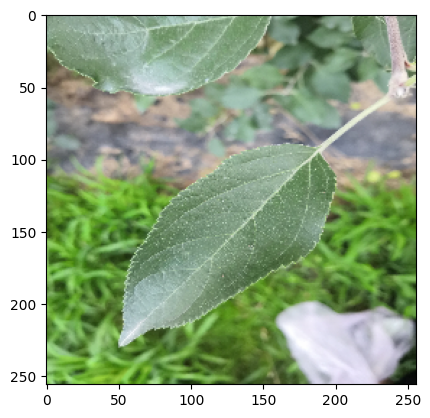

Prediction: 60.37% | Prediction: Apple - healthy | Actual: Apple - healthy


In [27]:
image, index = next(iter(train_loader))

image = image.to(device)
pred = net(image)

pred_label = pred.argmax(dim=1).int()
pred_value = torch.nn.functional.softmax(pred[0], dim=0)
percentage = (pred_value.max() * 100).cpu().item()

image = image[0].cpu().numpy().astype(np.uint8)
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.show()
print(f"Prediction: {percentage:.2f}% | Prediction: {idx_to_class[pred_label[0].item()]} | Actual: {idx_to_class[index[0].item()]}")